In [1]:
from pyquery import PyQuery as pq
from pprint import pprint
from functools import wraps
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [2]:
def load_data(data_file: "html", ret_flag: int=0)->tuple:
    text = [item.text() for item in data_file.items("pre")]
    text = text[0].split()
    text = text[3:] # del table 
    del(text[2::3]) # del sigma from data
    
    date = np.array(text[0::2]).astype(float).astype(int) # convert str to int
    
    data_value = np.array(text[1::2]).astype(float) # convert str value to float
    
    if ret_flag:
        return data_value, date
    return data_value

### Апроксимация с помощью МНК

In [3]:
# загрузка данных (data, x, y, lod) для 2000-2014г.
x_data = pq(filename="data_html/data_x_2000_2014.htm")
y_data = pq(filename="data_html/data_y_2000_2014.htm")
lod_data = pq(filename="data_html/data_lod_2000_2014.htm")
delta_data = pq(filename="data_html/ut`_utc_2000_2014.htm")

In [4]:
x_coord, date = load_data(x_data, 1)
y_coord = load_data(y_data)
lod = load_data(lod_data)
delta = load_data(delta_data)

Зададим нобходимые константы

In [5]:
tau_scale = 1 / 365.25
N = 0.85
Vm = 13.25
Vf = 26.73

Зададим матрицу коэф. для аппроксимации $x$

In [6]:
coef_matrix = [[1,
                tau_scale * tau, 
                -np.cos(2 * np.pi * N * tau_scale * tau), 
                np.sin(np.pi * 2 * N * tau_scale * tau), 
                -N * np.cos(2 * np.pi * tau_scale * tau), 
                -np.sin(2 * np.pi * tau_scale * tau)] for tau in date]

МНК

In [7]:
cx0, cx1, axc, axs, dxc, dxs = np.linalg.lstsq(coef_matrix, x_coord, rcond=None)[0]

In [8]:
x_forec = cx0 + cx1 * date * tau_scale \
        - axc * np.cos(2 * np.pi * N * date * tau_scale) \
        + axs * np.sin(np.pi * 2 * N * date * tau_scale) \
        -dxc * N * np.cos(2 * np.pi * date * tau_scale) \
        - dxs * np.sin(2 * np.pi * date * tau_scale)

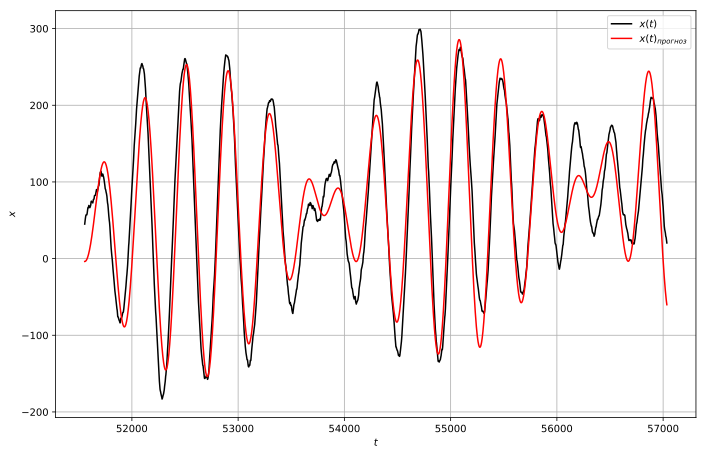

In [9]:
plt.figure(figsize=(11.5, 7.5))

plt.grid(True)
plt.ylabel("$x$")
plt.xlabel("$t$")
plt.plot(date, x_coord, color="black", label="$x(t)$")
plt.plot(date, x_forec, color="red", label="$x(t)_{прогноз}$")
plt.legend()

plt.savefig("./figures/x_forec.svg", format="svg")
plt.show()

Зададим матрицу для опредедения $y$


In [10]:
coef_matrix = [[1,
                tau_scale * tau, 
                np.cos(2 * np.pi * N * tau_scale * tau), 
                np.sin(np.pi * 2 * N * tau_scale * tau), 
                -N * np.cos(2 * np.pi * tau_scale * tau), 
                np.sin(2 * np.pi * tau_scale * tau)] for tau in date]

МНК


In [11]:
cy0, cy1, ayc, ays, dyc, dys = np.linalg.lstsq(coef_matrix, y_coord, rcond=None)[0]

In [12]:
y_forec = cy0 + cy1 * date * tau_scale \
        + ayc * np.cos(2 * np.pi * N * date * tau_scale) \
        + ays * np.sin(np.pi * 2 * N * date * tau_scale) \
        - dyc * N * np.cos(2 * np.pi * date * tau_scale) \
        + dys * np.sin(2 * np.pi * date * tau_scale)

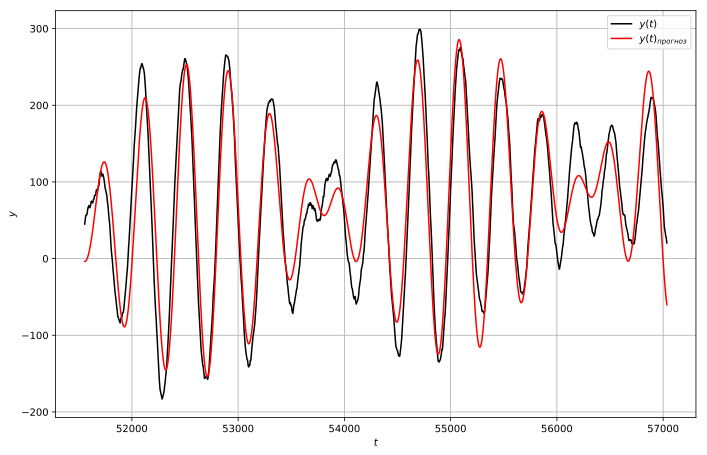

In [13]:
plt.figure(figsize=(11.5, 7.5))

plt.grid(True)
plt.ylabel("$y$")
plt.xlabel("$t$")
plt.plot(date, x_coord, color="black", label="$y(t)$")
plt.plot(date, x_forec, color="red", label="$y(t)_{прогноз}$")
plt.legend()

plt.savefig("./figures/y_forec.svg", format="svg")
plt.show()

Найдем среднеквадратическую ошибку

In [14]:
rms_x = np.sqrt(mean_squared_error(x_coord, x_forec))
rms_y = np.sqrt(mean_squared_error(y_coord, y_forec))
print("ошибка по х: {} \t\t ошибка по y: {}".format(rms_x, rms_y))

ошибка по х: 41.729912014846555 		 ошибка по y: 41.10647206048373


### Прогноз используя полученную модель

In [15]:
# Прогнозируем х
def xp_forec(t, c_0, c_1, a_c, a_s, d_c, d_s, N, tau_scale = 1/365.25):
    return c_0 + c_1 * t * tau_scale - \
        a_c * np.cos(2 * np.pi * N * t * tau_scale) + \
        a_s * np.sin(2 * np.pi * N * t * tau_scale) - \
        N * d_c * np.cos(2 * np.pi * t * tau_scale) - \
        d_s * np.sin(2 * np.pi * t * tau_scale)

In [16]:
# Прогнозируем y
def yp_forec(t, c_0, c_1, a_c, a_s, d_c, d_s, N, tau_scale = 1/365.25):
    return c_0 + c_1 * t * tau_scale + \
        a_c * np.cos(2 * np.pi * N * t * tau_scale) + \
        a_s * np.sin(2 * np.pi * N * t * tau_scale) - \
        N * d_c * np.cos(2 * np.pi * t * tau_scale) + \
        d_s * np.sin(2 * np.pi * t * tau_scale)

In [18]:
# загрузка данных (data, x, y, lod) для 2015-2016г.
x_data = pq(filename='data_html/y_2015_2016.htm')
y_data = pq(filename='data_html/x_2015_2016.htm')

x_coord, date = load_data(x_data, 1)
y_coord = load_data(y_data)

In [20]:
# ошибка на этапе прозноза
x_for = xp_forec(date, cx0, cx1, axc, axs, dxc, dxs, N)
y_for = yp_forec(date, cy0, cy1, ayc, ays, dyc, dys, N)

rms_x = np.sqrt(mean_squared_error(x_coord, x_for))
rms_y = np.sqrt(mean_squared_error(y_coord, y_for))
print("ошибка по х: {} \t\t ошибка по y: {}".format(rms_x, rms_y))

ошибка по х: 62.22192098112978 		 ошибка по y: 62.20786215709139


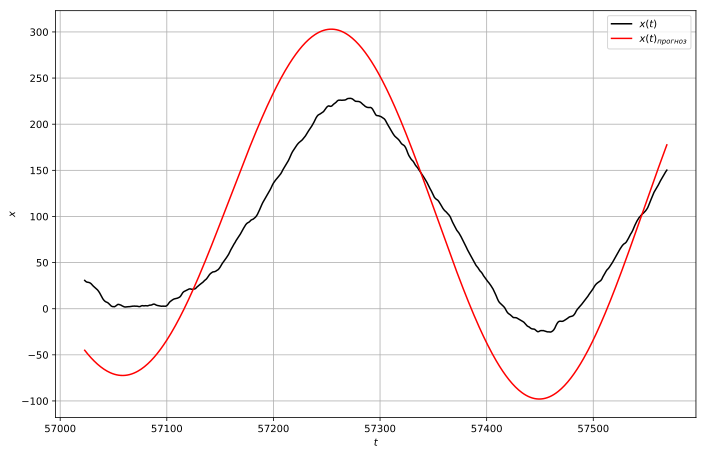

In [21]:
plt.figure(figsize=(11.5, 7.5))

plt.grid(True)
plt.ylabel("$x$")
plt.xlabel("$t$")
plt.plot(date, x_coord, color="black", label="$x(t)$")
plt.plot(date, x_for, color="red", label="$x(t)_{прогноз}$")
plt.legend()

plt.savefig("./figures/x_forec_2.svg", format="svg")
plt.show()

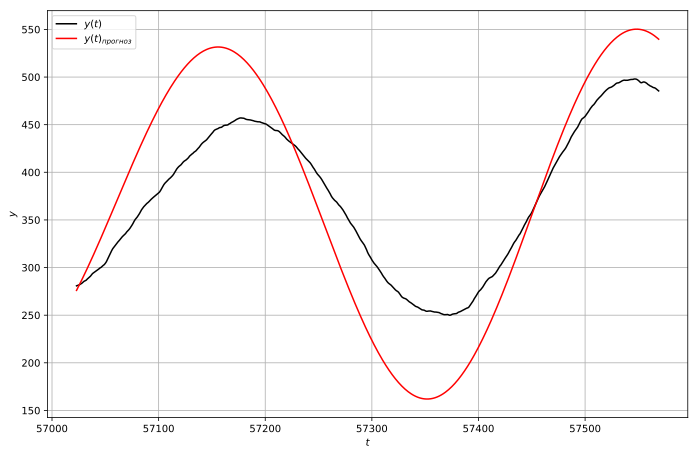

In [22]:
plt.figure(figsize=(11.5, 7.5))

plt.grid(True)
plt.ylabel("$y$")
plt.xlabel("$t$")
plt.plot(date, y_coord, color="black", label="$y(t)$")
plt.plot(date, y_for, color="red", label="$y(t)_{прогноз}$")
plt.legend()

plt.savefig("./figures/y_forec_2.svg", format="svg")
plt.show()